In [1]:
# ============================================================================
# CELL 1: Imports and Setup
# ============================================================================
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import time

from src.config import DataConfig, BaselineConfig, MODELS_DIR, PROCESSED_DATA_DIR
from src.utils import Timer

print("Imports successful!")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\Fake_News_Detection_BERT\venv\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "d:\Fake_News_Detection_BERT\venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "d:\Fake_News_Detection_BERT\venv\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start
    self.io_loop.start()
  File "d:\Fake_News_D

✅ Transformers 4.39.3 loaded successfully
Imports successful!


In [ ]:
# ============================================================================
# CELL 2: Load Data
# ============================================================================
print("="*80)
print("LOADING DATA")
print("="*80)

# Load processed data
train_df = pd.read_csv(PROCESSED_DATA_DIR / DataConfig.TRAIN_FILE)
val_df = pd.read_csv(PROCESSED_DATA_DIR / DataConfig.VAL_FILE)
test_df = pd.read_csv(PROCESSED_DATA_DIR / DataConfig.TEST_FILE)

print(f"\n Data loaded!")
print(f"   Training:   {len(train_df):,} samples")
print(f"   Validation: {len(val_df):,} samples")
print(f"   Test:       {len(test_df):,} samples")

# Extract features and labels
X_train = train_df[DataConfig.CLEANED_TEXT_COLUMN]
y_train = train_df[DataConfig.LABEL_COLUMN]

X_val = val_df[DataConfig.CLEANED_TEXT_COLUMN]
y_val = val_df[DataConfig.LABEL_COLUMN]

X_test = test_df[DataConfig.CLEANED_TEXT_COLUMN]
y_test = test_df[DataConfig.LABEL_COLUMN]


LOADING DATA

✅ Data loaded!
   Training:   95,244 samples
   Validation: 20,409 samples
   Test:       20,410 samples


In [ ]:
# ============================================================================
# CELL 3: TF-IDF Vectorization
# ============================================================================
print("\n" + "="*80)
print("TF-IDF VECTORIZATION")
print("="*80)

with Timer("TF-IDF vectorization"):
    # Initialize vectorizer
    vectorizer = TfidfVectorizer(
        max_features=BaselineConfig.MAX_FEATURES,
        min_df=BaselineConfig.MIN_DF,
        max_df=BaselineConfig.MAX_DF,
        ngram_range=BaselineConfig.NGRAM_RANGE
    )
    
    # Fit and transform training data
    X_train_tfidf = vectorizer.fit_transform(X_train)
    
    # Transform validation and test data
    X_val_tfidf = vectorizer.transform(X_val)
    X_test_tfidf = vectorizer.transform(X_test)

print(f"\n Vectorization complete!")
print(f"   Vocabulary size: {len(vectorizer.vocabulary_):,}")
print(f"   Train shape: {X_train_tfidf.shape}")
print(f"   Val shape:   {X_val_tfidf.shape}")
print(f"   Test shape:  {X_test_tfidf.shape}")

# Top features
feature_names = vectorizer.get_feature_names_out()
print(f"\n Sample features:")
print(f"   {feature_names[:20].tolist()}")


TF-IDF VECTORIZATION
⏱️  TF-IDF vectorization started...
✅ TF-IDF vectorization completed in 110.55 seconds

✅ Vectorization complete!
   Vocabulary size: 10,000
   Train shape: (95244, 10000)
   Val shape:   (20409, 10000)
   Test shape:  (20410, 10000)

📝 Sample features:
   ['00', '000', '000 in', '000 people', '000 to', '10', '10 000', '10 million', '10 percent', '10 years', '100', '100 000', '11', '12', '120', '13', '14', '15', '15 percent', '15 years']


In [ ]:
# ============================================================================
# CELL 4: Train Logistic Regression
# ============================================================================
print("\n" + "="*80)
print("TRAINING LOGISTIC REGRESSION")
print("="*80)

with Timer("Model training"):
    # Initialize model
    model = LogisticRegression(
        solver=BaselineConfig.SOLVER,
        max_iter=BaselineConfig.MAX_ITER,
        C=BaselineConfig.C,
        random_state=42,
        verbose=1
    )
    
    # Train
    model.fit(X_train_tfidf, y_train)

print("\n Training complete!")


TRAINING LOGISTIC REGRESSION
⏱️  Model training started...
✅ Model training completed in 2.48 seconds

✅ Training complete!


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished


In [ ]:
# ============================================================================
# CELL 5: Evaluate on Validation Set
# ============================================================================
print("\n" + "="*80)
print("VALIDATION SET EVALUATION")
print("="*80)

# Predictions
y_val_pred = model.predict(X_val_tfidf)
y_val_prob = model.predict_proba(X_val_tfidf)

# Calculate metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print(f"\n Validation Metrics:")
print(f"   Accuracy:  {val_accuracy:.4f}")
print(f"   Precision: {val_precision:.4f}")
print(f"   Recall:    {val_recall:.4f}")
print(f"   F1-Score:  {val_f1:.4f}")


VALIDATION SET EVALUATION

📊 Validation Metrics:
   Accuracy:  0.8882
   Precision: 0.8709
   Recall:    0.8943
   F1-Score:  0.8824


In [ ]:
# ============================================================================
# CELL 6: Evaluate on Test Set
# ============================================================================
print("\n" + "="*80)
print("TEST SET EVALUATION")
print("="*80)

# Predictions
y_test_pred = model.predict(X_test_tfidf)
y_test_prob = model.predict_proba(X_test_tfidf)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"\n Test Metrics:")
print(f"   Accuracy:  {test_accuracy:.4f}")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")

# Classification report
print(f"\n Classification Report:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Real (0)', 'Fake (1)']))


TEST SET EVALUATION

📊 Test Metrics:
   Accuracy:  0.8898
   Precision: 0.8743
   Recall:    0.8933
   F1-Score:  0.8837

📋 Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.90      0.89      0.90     10837
    Fake (1)       0.87      0.89      0.88      9573

    accuracy                           0.89     20410
   macro avg       0.89      0.89      0.89     20410
weighted avg       0.89      0.89      0.89     20410




CONFUSION MATRIX
✅ Confusion matrix saved!


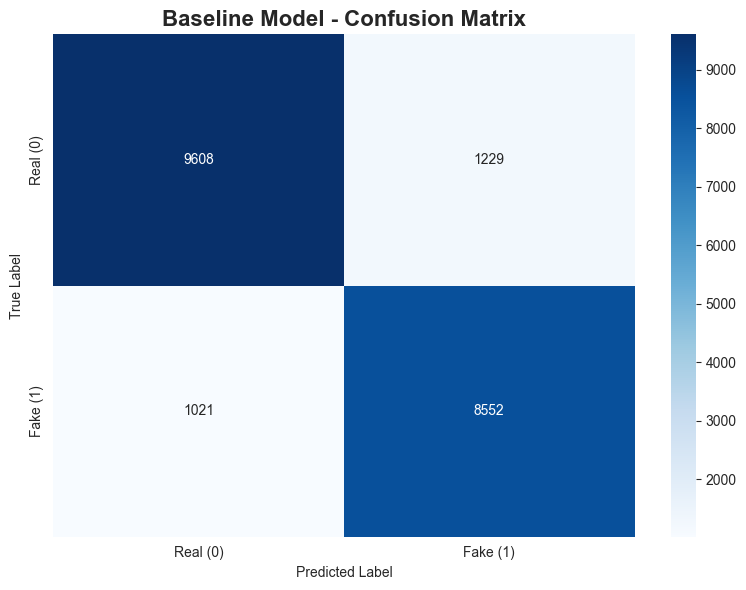

In [ ]:
# ============================================================================
# CELL 7: Confusion Matrix
# ============================================================================
print("\n" + "="*80)
print("CONFUSION MATRIX")
print("="*80)

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Real (0)', 'Fake (1)'],
           yticklabels=['Real (0)', 'Fake (1)'])
plt.title('Baseline Model - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../results/visualizations/baseline_confusion_matrix.png', dpi=300)
print("Confusion matrix saved!")
plt.show()


FEATURE IMPORTANCE

🔴 Top 20 features for FAKE news:
    1. via                  (20.5723)
    2. featured image       (10.0325)
    3. featured             ( 9.5727)
    4. read more            ( 9.5671)
    5. image via            ( 8.9484)
    6. video                ( 8.0946)
    7. twitter com          ( 7.9393)
    8. hillary              ( 7.1669)
    9. the us               ( 6.5590)
   10. getty                ( 6.4219)
   11. 2016                 ( 6.2406)
   12. october              ( 6.1412)
   13. getty images         ( 6.0659)
   14. com                  ( 6.0212)
   15. november             ( 5.0130)
   16. anti                 ( 4.5151)
   17. this                 ( 4.4477)
   18. president trump      ( 4.3601)
   19. images               ( 4.0460)
   20. just                 ( 3.9920)

🟢 Top 20 features for REAL news:
    1. said                 (-13.9025)
    2. on twitter           (-10.8145)
    3. president donald     (-10.5251)
    4. said on              (-10.16

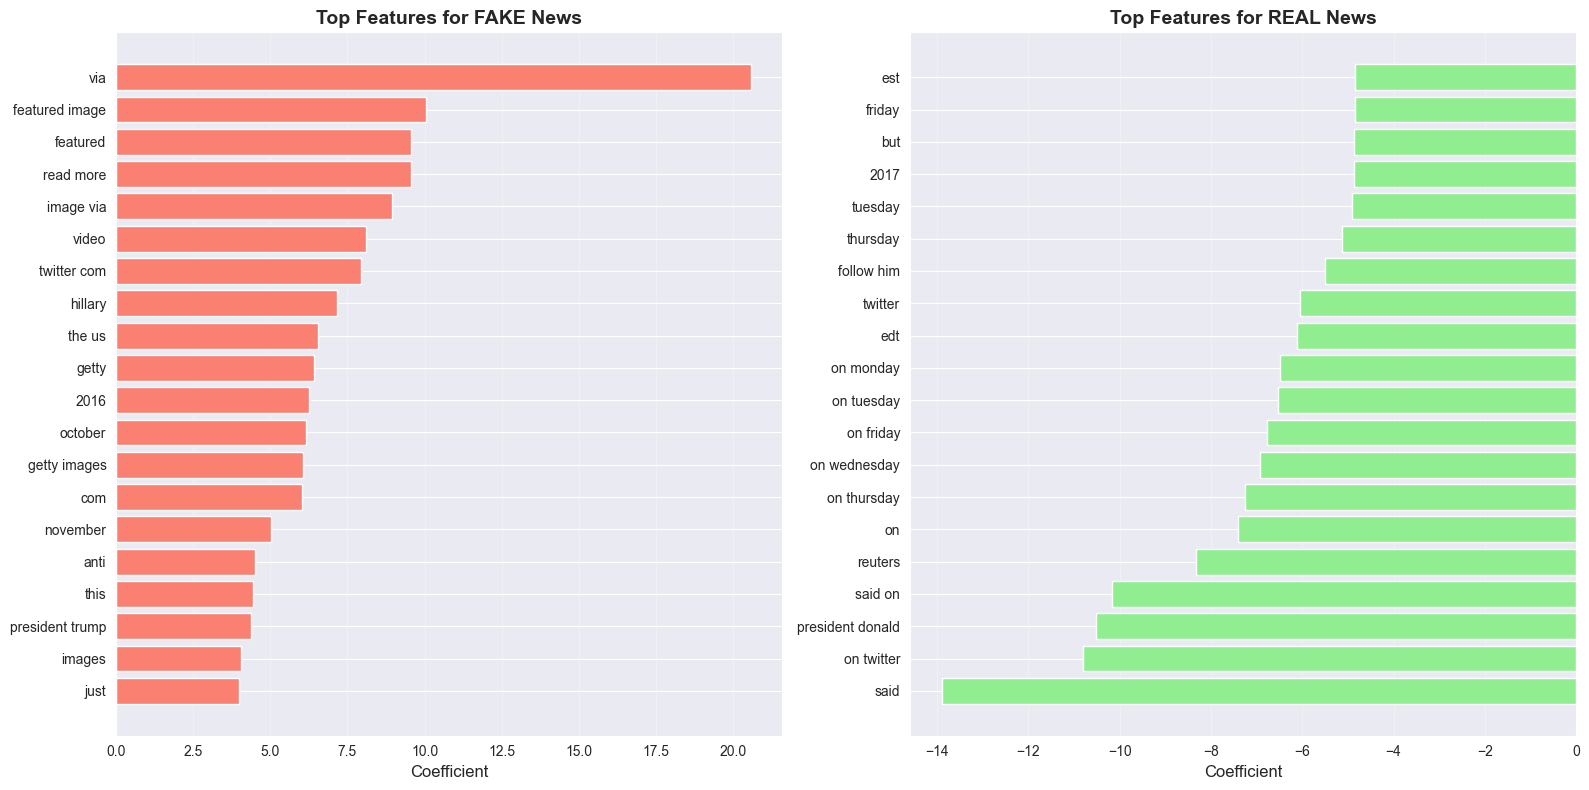

In [ ]:
# ============================================================================
# CELL 8: Feature Importance
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE")
print("="*80)

# Get coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

# Top features for each class
top_n = 20

# Features indicating FAKE news (positive coefficients)
fake_indices = np.argsort(coefficients)[-top_n:]
fake_features = [(feature_names[i], coefficients[i]) for i in fake_indices]

# Features indicating REAL news (negative coefficients)
real_indices = np.argsort(coefficients)[:top_n]
real_features = [(feature_names[i], coefficients[i]) for i in real_indices]

print(f"\nTop {top_n} features for FAKE news:")
for i, (feature, coef) in enumerate(reversed(fake_features), 1):
    print(f"   {i:2d}. {feature:20s} ({coef:7.4f})")

print(f"\nTop {top_n} features for REAL news:")
for i, (feature, coef) in enumerate(real_features, 1):
    print(f"   {i:2d}. {feature:20s} ({coef:7.4f})")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Fake news features
fake_df = pd.DataFrame(fake_features, columns=['feature', 'coefficient'])
axes[0].barh(range(top_n), fake_df['coefficient'], color='salmon')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(fake_df['feature'])
axes[0].set_xlabel('Coefficient', fontsize=12)
axes[0].set_title('Top Features for FAKE News', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Real news features
real_df = pd.DataFrame(real_features, columns=['feature', 'coefficient'])
axes[1].barh(range(top_n), real_df['coefficient'], color='lightgreen')
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(real_df['feature'])
axes[1].set_xlabel('Coefficient', fontsize=12)
axes[1].set_title('Top Features for REAL News', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/feature_importance.png', dpi=300, bbox_inches='tight')
print("Feature importance plot saved!")
plt.show()

In [ ]:
# ============================================================================
# CELL 9: Save Model
# ============================================================================
print("\n" + "="*80)
print("SAVING MODEL")
print("="*80)

# Create models directory
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Save vectorizer
vectorizer_path = MODELS_DIR / BaselineConfig.TFIDF_VECTORIZER_FILE
with open(vectorizer_path, 'wb') as f:
    pickle.dump(vectorizer, f)
print(f"Vectorizer saved to: {vectorizer_path}")

# Save model
model_path = MODELS_DIR / BaselineConfig.BASELINE_MODEL_FILE
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"Model saved to: {model_path}")


SAVING MODEL
✅ Vectorizer saved to: d:\Fake_News_Detection_BERT\notebooks\..\models\tfidf_vectorizer.pkl
✅ Model saved to: d:\Fake_News_Detection_BERT\notebooks\..\models\baseline_logistic_regression.pkl


In [ ]:
# ============================================================================
# CELL 10: Test Prediction Function
# ============================================================================
print("\n" + "="*80)
print("TESTING PREDICTION FUNCTION")
print("="*80)

def predict_baseline(text, vectorizer, model):
    """Predict using baseline model"""
    # Vectorize
    text_tfidf = vectorizer.transform([text])
    
    # Predict
    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0]
    
    return prediction, probability

# Test samples
import pandas as pd
test_df = pd.read_csv("D:/Fake_News_Detection_BERT/data/sample/test_sample.csv")

# test_samples = [
#     "Breaking news: Scientists discover cure for cancer in major breakthrough",
#     "You won't believe what happened next! Click here for shocking truth",
#     "The president announced new economic policies in a press conference today",
#     "Aliens landed in New York and nobody noticed! Government cover-up exposed"
# ]

print("\n Sample Predictions:\n")
for i, text in enumerate(test_df['content'], 1):
    pred, prob = predict_baseline(text, vectorizer, model)
    print(f"Sample {i}:")
    print(f"   Text: {text}")
    print(f"   Prediction: {'FAKE' if pred == 1 else 'REAL'}")
    print(f"   Confidence: Real={prob[0]:.3f}, Fake={prob[1]:.3f}")
    print()
# for i, text in enumerate(test_samples, 1):
#     pred, prob = predict_baseline(text, vectorizer, model)
#     print(f"Sample {i}:")
#     print(f"   Text: {text}")
#     print(f"   Prediction: {'FAKE' if pred == 1 else 'REAL'}")
#     print(f"   Confidence: Real={prob[0]:.3f}, Fake={prob[1]:.3f}")
#     print()



TESTING PREDICTION FUNCTION

🔍 Sample Predictions:

Sample 1:
   Text: Trump’s Gettysburg Address against the New World Order ‹ › Professor and Attorney Rahul Manchanda worked for one of the largest law firms in Manhattan where he focused on asbestos litigation. At the United Nations Commission on International Trade Law (“UNCITRAL”) in Vienna, Austria, Mr. Manchanda was exposed to international trade law, arbitration, alternative dispute resolution, and comparisons of the American common law with European civil law. He later worked for one of the largest multi-national law firms in Paris France, Coudert Frères, where he focused primarily on international arbitration, arbitration agreements, the enforcement of foreign arbitration awards against multinational parent corporations, piercing the corporate veil, arbitration venue choice, and foreign policy. In Paris, Mr. Manchanda analyzed and compared the American legal system with its British, French, Russian, German, and Chinese counter

In [ ]:
# ============================================================================
# CELL 11: Save Baseline Results
# ============================================================================
print("\n" + "="*80)
print("SAVING BASELINE RESULTS")
print("="*80)

from src.utils import save_json

baseline_results = {
    "model": "TF-IDF + Logistic Regression",
    "vectorizer_config": {
        "max_features": BaselineConfig.MAX_FEATURES,
        "min_df": BaselineConfig.MIN_DF,
        "max_df": BaselineConfig.MAX_DF,
        "ngram_range": BaselineConfig.NGRAM_RANGE
    },
    "validation_metrics": {
        "accuracy": float(val_accuracy),
        "precision": float(val_precision),
        "recall": float(val_recall),
        "f1_score": float(val_f1)
    },
    "test_metrics": {
        "accuracy": float(test_accuracy),
        "precision": float(test_precision),
        "recall": float(test_recall),
        "f1_score": float(test_f1)
    },
    "vocabulary_size": len(vectorizer.vocabulary_),
    "training_samples": len(train_df)
}

results_path = MODELS_DIR / "baseline_results.json"
save_json(baseline_results, results_path)
print(f" Results saved to: {results_path}")


SAVING BASELINE RESULTS
✅ Saved JSON to: d:\Fake_News_Detection_BERT\notebooks\..\models\baseline_results.json
✅ Results saved to: d:\Fake_News_Detection_BERT\notebooks\..\models\baseline_results.json


In [ ]:
# ============================================================================
# CELL 12: Summary
# ============================================================================
print("\n" + "="*80)
print("BASELINE MODEL COMPLETE! ")
print("="*80)

print("\n Final Results:")
print(f"   Model: TF-IDF + Logistic Regression")
print(f"   Vocabulary Size: {len(vectorizer.vocabulary_):,}")
print(f"   Test Accuracy: {test_accuracy:.4f}")
print(f"   Test F1-Score: {test_f1:.4f}")

print("\n Saved Files:")
print(f"   ✓ Model: {model_path}")
print(f"   ✓ Vectorizer: {vectorizer_path}")
print(f"   ✓ Results: {results_path}")
print(f"   ✓ Confusion Matrix: ../results/visualizations/baseline_confusion_matrix.png")
print(f"   ✓ Feature Importance: ../results/visualizations/feature_importance.png")


print("\n" + "="*80)


BASELINE MODEL COMPLETE! ✅

📊 Final Results:
   Model: TF-IDF + Logistic Regression
   Vocabulary Size: 10,000
   Test Accuracy: 0.8898
   Test F1-Score: 0.8837

📁 Saved Files:
   ✓ Model: d:\Fake_News_Detection_BERT\notebooks\..\models\baseline_logistic_regression.pkl
   ✓ Vectorizer: d:\Fake_News_Detection_BERT\notebooks\..\models\tfidf_vectorizer.pkl
   ✓ Results: d:\Fake_News_Detection_BERT\notebooks\..\models\baseline_results.json
   ✓ Confusion Matrix: ../results/visualizations/baseline_confusion_matrix.png
   ✓ Feature Importance: ../results/visualizations/feature_importance.png

🎯 Next Steps:
   1. Run BERT model training
      >>> jupyter notebook notebooks/04_bert_training.ipynb

   2. Compare baseline vs BERT performance

   3. This baseline will serve as benchmark (expect ~80-85% accuracy)

